<a href="https://colab.research.google.com/github/mpipher2/SCS_3253_ML_NLP/blob/master/ML_final_cannabis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Cannabis Dataset</h1>
<h2>SCS_3253_Machine_Learning</h2>
Due: August 1, 2019<br>
By: Taylor Van Valkenburg,  Kristen Celotto, Victor Hugo Mazariegos, and Mark Pipher

In [0]:
#imports
import os
import pandas as pd
import numpy as np
import string

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.externals import joblib
from sklearn.neighbors import KNeighborsClassifier

# ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

import gensim

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('word_tokenize')
nltk.download('punkt')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Error loading word_tokenize: Package 'word_tokenize' not
[nltk_data]     found in index
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
#load the data
df1 = pd.read_csv('https://raw.githubusercontent.com/mpipher2/SCS_3253_ML_NLP/master/cannabis.csv')

### Part 1: Data Preparation and Exploratory Data Analysis

Basic overview of the data

In [0]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351 entries, 0 to 2350
Data columns (total 6 columns):
Strain         2351 non-null object
Type           2351 non-null object
Rating         2351 non-null float64
Effects        2351 non-null object
Flavor         2305 non-null object
Description    2318 non-null object
dtypes: float64(1), object(5)
memory usage: 110.3+ KB


In [0]:
df1.describe()

,Rating
count,2351.000000
mean,4.310634
std,0.836394
min,0.000000
25%,4.200000
50%,4.400000
75%,4.700000
max,5.000000


In [0]:
df1.head()

,Strain,Type,Rating,Effects,Flavor,Description
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",$100 OG is a 50/50 hybrid strain that packs a ...
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",The ‘98 Aloha White Widow is an especially pot...
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1024 is a sativa-dominant hybrid bred in Spain...
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",13 Dawgs is a hybrid of G13 and Chemdawg genet...
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange","Also known as Kosher Tangie, 24k Gold is a 60%..."


Based on the quick overview of the data, we can see that the dataset contains just over two thousand strains of cannabis as well as contains the information regarding the description, effect, flavor, type and customer rating. <br><br>
​
We wanted to design a model that can accuractly predict customer ratings of new strains that come on to the market based on the their attributes. This will be useful for companies and investors to decided if a strain will be worth stocking or investing in. <br><br>
​
Looking at the attribute types we notice that all of the attributes are categorical and our target variable 'Rating' is a continuous ranging from 0 to 5 however the question we are trying to answer deals with our target variable being categorical so in later cells you will see we convert the only continuous value to be categorical. <br>
<br>
Through the info function we can see that there are null values in both flavor and description. To fill in the null values of flavor we will look to see if flavor is mentioned in the description if it is then we can manually enter those flavors into the flavor attribute. However any remaining strains that have null flavors or descriptions should be deleted since they are text we have no way of filling them in with reasonable certainty. <br><br>
​
Observing the the distribution of ratings we can see there is a strong left skew of the target value 'Rating' with the median value being 4.4 out of a range of 0 to 5.

<h4> Searching for duplicate strains in the dataset</h4>

In [0]:
# Next check for non unique/duplicated strains 
df1.loc[df1['Strain'].duplicated()]

,Strain,Type,Rating,Effects,Flavor,Description
151,B-Witched,hybrid,5.0,"Euphoric,Relaxed,Happy,Hungry,Sleepy","Earthy,Sweet,Citrus",B-Witched by Ocean Grown Seeds is a magical cr...


In [0]:
# so looking at the strains only one is duplicated which is B-Witched strain which is delete the duplicate
print(df1.loc[df1['Strain']== 'B-Witched'])
df1.drop(df1.index[[151]], inplace=True)

        Strain  ...                                        Description
150  B-Witched  ...  B-Witched by Ocean Grown Seeds is a magical cr...
151  B-Witched  ...  B-Witched by Ocean Grown Seeds is a magical cr...

[2 rows x 6 columns]


In [0]:
df1.loc[df1['Strain']== 'B-Witched']

,Strain,Type,Rating,Effects,Flavor,Description
150,B-Witched,hybrid,5.0,"Euphoric,Relaxed,Happy,Hungry,Sleepy","Earthy,Sweet,Citrus",B-Witched by Ocean Grown Seeds is a magical cr...


<h4>Exploring data distribution</h4>

In [0]:
# How the rating are distributed by type
df1['Type'].value_counts()

hybrid    1211
indica     699
sativa     440
Name: Type, dtype: int64

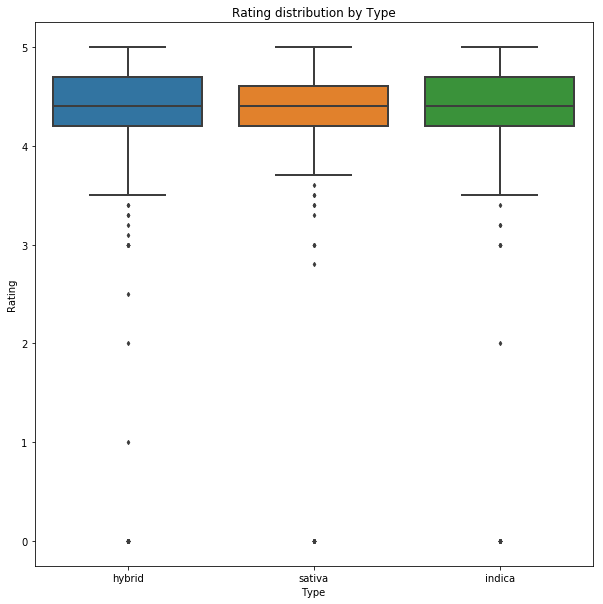

In [0]:
## Observing the rating with respect to the types
%matplotlib inline
plt.figure(figsize=(10,10))
## set ax as axis
ax = sns.boxplot(x="Type",y='Rating', data=df1, fliersize=3, linewidth=2)
ax.set(xlabel="Type", ylabel="Rating", title="Rating distribution by Type")
plt.show()

We can also visualy see by the boxplot and the percentales that the rating are heavily in the higher ratings. However we are interest in helping companies decide what strains to stock so to better split the rating we sperate the rating into three categories that are more distributed.


The boxplot shows that although hybrid has more strain as hybrid time all three types have similar medians.


 To deal with such a strong skew we will using synthetic Minority Oversampling Technique
 
 
 We can also see that any customer rating below 3.5 is considered an outlier.

<h3> Dealing with null values in flavor </h3>
First we must look to see if flavor is mentioned in the descriptions for strains that have null flavors.
Following that we will manually enter the flavors in the flavor feature.
Once that is complete we will delete any strain that still has either a null value in description or flavor.

In [0]:
## number of null values that have flavor mentioned in the descriptions
df1[df1['Flavor'].isnull()].Description.str.contains('flavor').sum()

8

In [0]:
## Looking to see if there is any flavors in the description that we can input back into the flavor columns
df1[df1['Flavor'].isnull() & df1[df1['Flavor'].isnull()]['Description'].str.contains("flavor")]

,Strain,Type,Rating,Effects,Flavor,Description
103,Amethyst,hybrid,3.9,"Energetic,Creative,Giggly,Hungry,Happy",NaN,Amethyst is a hybrid cannabis strain from the ...
160,Bad-Azz-Kush,hybrid,5.0,None,NaN,Bad Azz Kush by Barney’s Farm was created with...
215,Birds-Eye,sativa,5.0,"Happy,Uplifted,Energetic,Euphoric,Relaxed",NaN,Birds Eye is a variety of Jack Herer grown by ...
673,Do-Over-Og,hybrid,4.7,"Talkative,Uplifted,Creative,Euphoric,Happy",NaN,Do-Over OG is an indica-dominant strain that c...
964,Grimmdica,indica,5.0,"Euphoric,Relaxed",NaN,Legendary Canadian breeders Brothers Grimm See...
1252,Lem-Chem,hybrid,4.0,"Energetic,Focused,Hungry",NaN,Lem Chem is a potent hybrid that is both sweet...
1771,Redd-Cross,hybrid,5.0,"Sleepy,Relaxed,Tingly,Hungry",NaN,Redd Cross is an indica-dominant hybrid bred b...
2181,Transformer,hybrid,4.0,"Sleepy,Tingly,Uplifted,Creative,Energetic",NaN,Transformer by Gage Green Genetics is a combin...


In [0]:
df1[df1['Flavor'].isnull() & df1[df1['Flavor'].isnull()]['Description'].str.contains("flavor")]['Description'].values

array(['Amethyst is a hybrid cannabis strain from the gardens of Zion Botanicals, who crossed parent strains Sage N Sour and Granddaddy Purple. This high-THC 50/50 hybrid provides a clear and focused buzz that sharpens the senses, making this a perfect pair for creative activities, enjoying nature, or productive afternoons. The inhale brings with it sweet and sour flavors ranging from spicy berry to tangy grape.',
       'Bad Azz Kush by Barney’s Farm was created with the help of rapper Bad Azz of Dogg Pound Gangsta Crips. While the full story remains untold, Bad Azz contributed to this new Kush cut that brings traditional OG elements to the table while elevating yield and flavor. Bad Azz Kush is known to express hash and berry aromas with an earthy, spicy flavor on the palate. It is a cross of OG Kush, Purple Urkle, and Afghan Kush. This strain’s weighted physical effects and carefree euphoria make it a perfect end of the day smoke.\xa0',
       'Birds Eye is a variety of Jack Herer g

Since there are 8 stains that include mentions of flavors we can add those flavors to the flavor category and leave the remain flavor nulls as empty strings  since there are possiblilty of a strain not having a flavor so leaving it empty could still provide information

In [0]:
## add flavor to flavor section if it contains flavors
df1.loc[df1['Strain'] == 'Amethyst', 'Flavor'] = "Grape,Sour,Sweet,Berry"
df1.loc[df1['Strain'] == 'Bad-Azz-Kush', 'Flavor'] = 'Berry,Spicy'
df1.loc[df1['Strain'] == 'Birds-Eye', 'Flavor'] = 'Sweet,Citrus,Spicy,Pine'
df1.loc[df1['Strain'] == 'Do-Over-Og', 'Flavor'] = 'Sweet'
df1.loc[df1['Strain'] == 'Grimmdica', 'Flavor'] = 'Pine'
df1.loc[df1['Strain'] == 'Lem-Chem', 'Flavor'] = 'Sweet,Sour'
df1.loc[df1['Strain'] == 'Redd-Cross', 'Flavor'] = 'Floral'
df1.loc[df1['Strain'] == 'Transformer', 'Flavor'] = 'Citrus,Woody'

In [0]:
## remain flavors that are null
df1[df1['Flavor'].isnull()]['Strain'].count()

38

###  Deleting null values and Converting data types from strings to list

In [0]:
#drop rows with missing values
df1 = df1.loc[pd.isnull(df1['Effects']) == False]
df1 = df1.loc[pd.isnull(df1['Flavor']) == False]
df1 = df1.loc[pd.isnull(df1['Description']) == False]

In [0]:
#convert dtypes
str_cols = ['Effects',
            'Flavor',
            'Description']

for col in str_cols:
    df1[col] = df1[col].astype(str)

In [0]:
#create the arrays
df1['Effects'] = df1['Effects'].apply(lambda x: x[0:].split(','))
df1['Flavor'] = df1['Flavor'].apply(lambda x: x[0:].split(','))

In [0]:
#bin the target variable
bins = np.array([4.2, 4.7])

df1['Rating_bin'] = np.digitize(df1['Rating'], bins=bins)

1    1343
2     579
0     362
Name: Rating_bin, dtype: int64


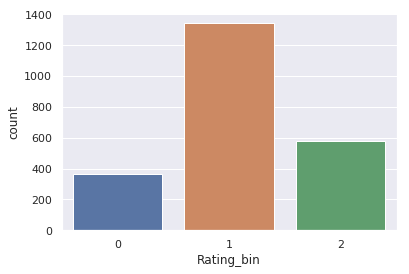

In [0]:
# Visually see how the strains are divided between the three rating bins
print(df1['Rating_bin'].value_counts())

sns.set(style="darkgrid")
ax = sns.countplot(x="Rating_bin", data=df1)

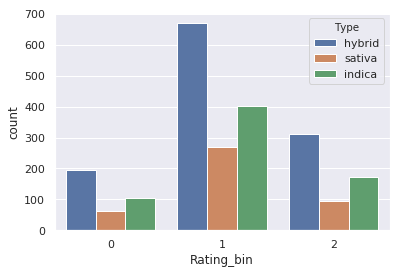

In [0]:
# Looking closer at how the types are divided within those counts
ax = sns.countplot(x="Rating_bin", hue="Type", data=df1)

From this visualization it clean to say that the marjoity of category 1 in rating_bin Hybrid has the largest bumber by far in that bin.

Also noticed that hybrid has the largest number of strains out of all three types of strains<br>

This graphs shows that the target categories are uneven with bin 1 (rating between 4.2-4.7) has the most strains within that range. To deal with this an make the model more accuate for the minority bins we will use Random Over sampling when creating our training set. This technique increase the amount the strains for bins 0 and 2 of ratings.

### Looking at the other attributes that include text.

In [0]:
df1.head(5)

,Strain,Type,Rating,Effects,Flavor,Description,Rating_bin
0,100-Og,hybrid,4.0,"[Creative, Energetic, Tingly, Euphoric, Relaxed]","[Earthy, Sweet, Citrus]",$100 OG is a 50/50 hybrid strain that packs a ...,0
1,98-White-Widow,hybrid,4.7,"[Relaxed, Aroused, Creative, Happy, Energetic]","[Flowery, Violet, Diesel]",The ‘98 Aloha White Widow is an especially pot...,2
2,1024,sativa,4.4,"[Uplifted, Happy, Relaxed, Energetic, Creative]","[Spicy/Herbal, Sage, Woody]",1024 is a sativa-dominant hybrid bred in Spain...,1
3,13-Dawgs,hybrid,4.2,"[Tingly, Creative, Hungry, Relaxed, Uplifted]","[Apricot, Citrus, Grapefruit]",13 Dawgs is a hybrid of G13 and Chemdawg genet...,1
4,24K-Gold,hybrid,4.6,"[Happy, Relaxed, Euphoric, Uplifted, Talkative]","[Citrus, Earthy, Orange]","Also known as Kosher Tangie, 24k Gold is a 60%...",1


### Visualizing the effect and flavor

In [0]:
## representing the different effects
# Exporing Effect by making a same dataframe to explore all the different effects and how they are related to the rating bins
effect_df = pd.get_dummies(pd.DataFrame(df1['Effects'].tolist()).stack()).sum(level=0)

In [0]:
effect_df['Type'] = df1['Type']
effect_df['Rating_bin'] = df1['Rating_bin']
effect_df['Rating'] = df1['Rating']

In [0]:
effect_df.head()

,Aroused,Creative,Dry,Energetic,Euphoric,Focused,Giggly,Happy,Hungry,Mouth,None,Relaxed,Sleepy,Talkative,Tingly,Uplifted,Type,Rating_bin,Rating
0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,hybrid,0.0,4.0
1,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,hybrid,2.0,4.7
2,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,sativa,1.0,4.4
3,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,hybrid,1.0,4.2
4,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,hybrid,1.0,4.6


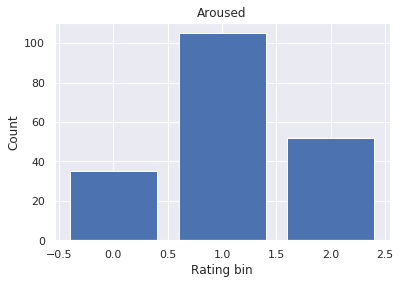

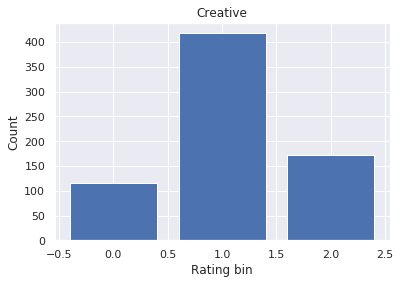

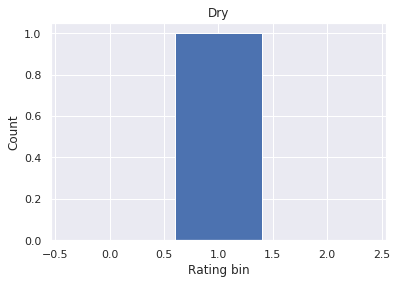

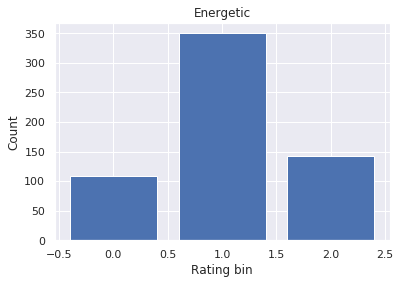

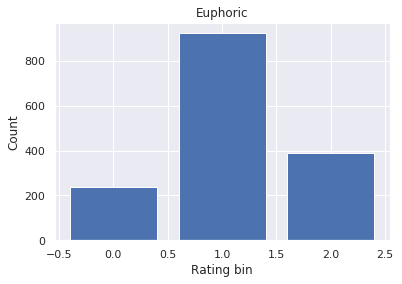

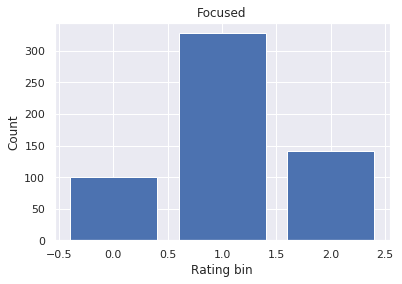

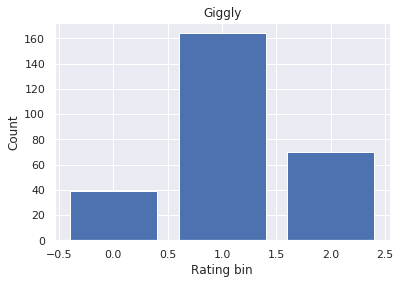

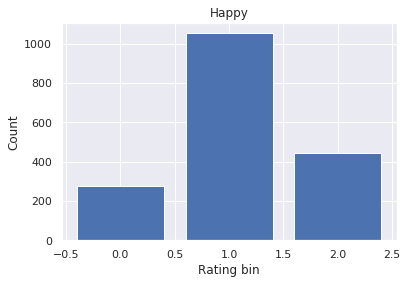

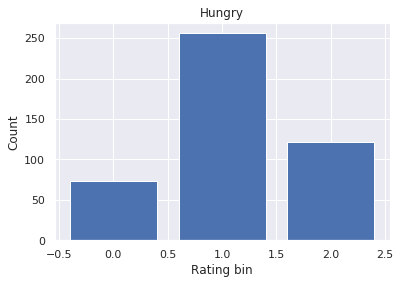

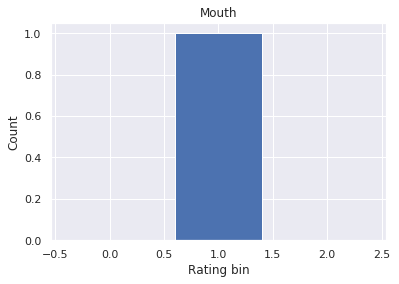

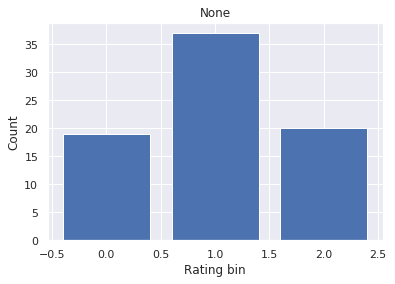

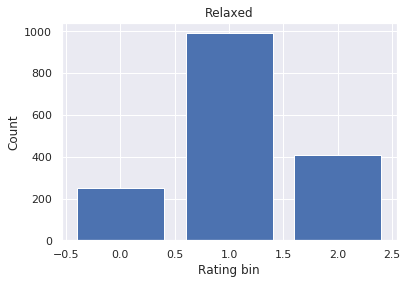

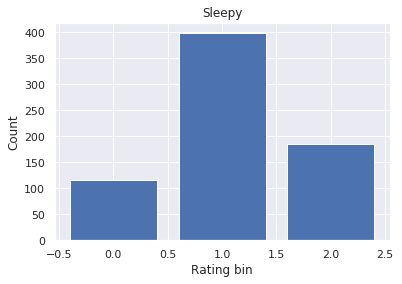

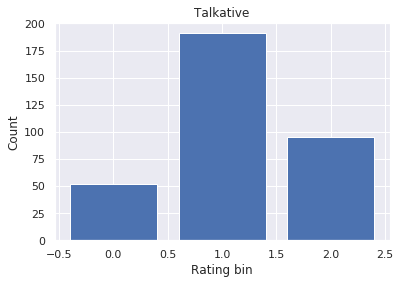

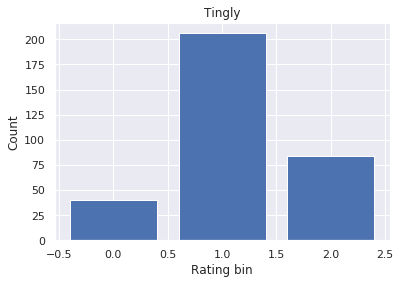

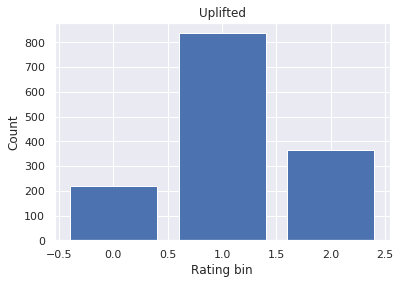

In [0]:
effect_x = effect_df.drop(['Type', 'Rating_bin','Rating'], axis=1).columns
effect_df['Rating_bin'].value_counts()
for effect in effect_x:
  effect_sum = []
  effect_sum.append(effect_df[effect_df['Rating_bin'] == 0][effect].sum())
  effect_sum.append(effect_df[effect_df['Rating_bin'] == 1][effect].sum())
  effect_sum.append(effect_df[effect_df['Rating_bin'] == 2][effect].sum())
  plt.bar(x=[0,1,2], height=effect_sum)
  plt.xlabel('Rating bin')
  plt.ylabel('Count')
  plt.title(effect)
  plt.show()
  print('\n\n')

From each indvidual graph they typically follow that same distribution between the bins as amount of strains are in that bin. With the exception Dry, Mouth and None, which have a larger proptation in bin 0 than any other bin. With Dry and Mouth they are effects that are only each once in all the strains.

### Visualizing Flavor

In [0]:
# Exporing Flavor by making a same dataframe to explore all the different flavors and how they are related to the rating bins
flavor_df = pd.get_dummies(pd.DataFrame(df1['Flavor'].tolist()).stack()).sum(level=0)

In [0]:
flavor_df['Type'] = df1['Type']
flavor_df['Rating_bin'] = df1['Rating_bin']

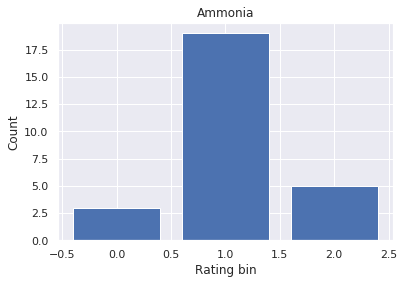

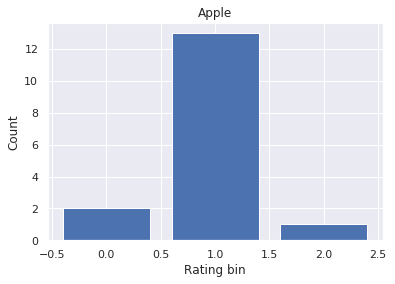

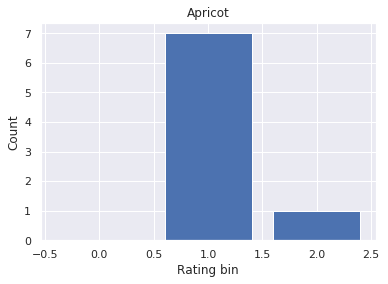

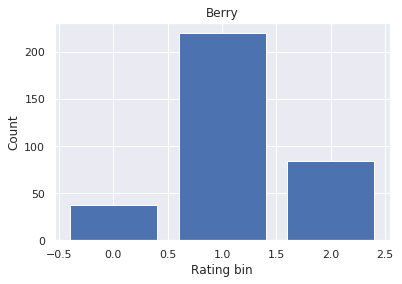

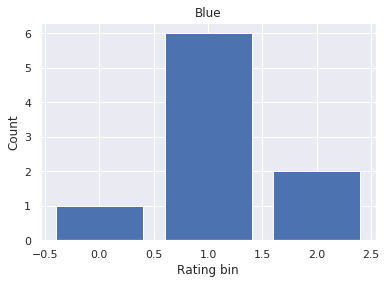

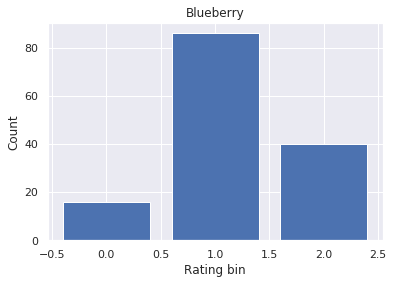

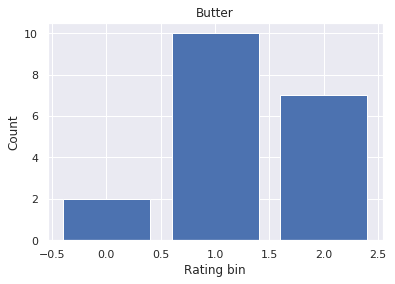

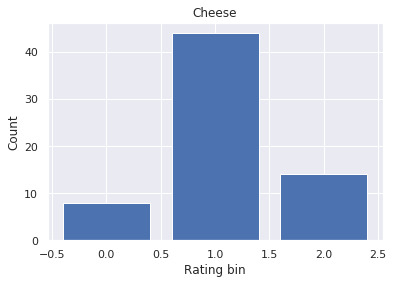

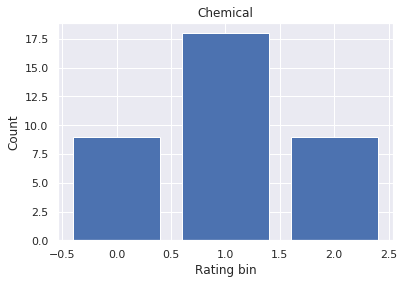

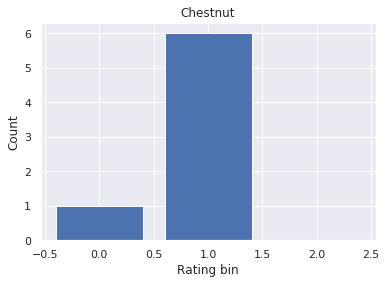

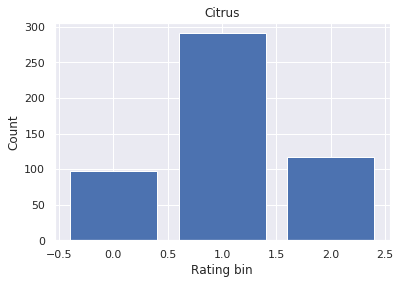

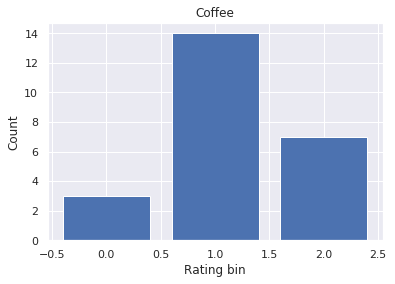

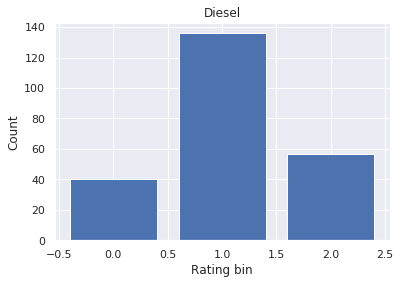

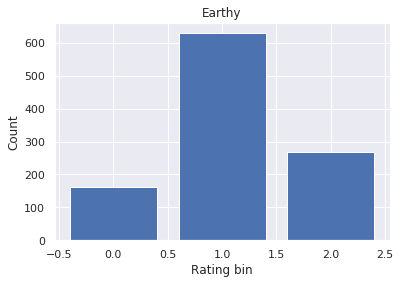

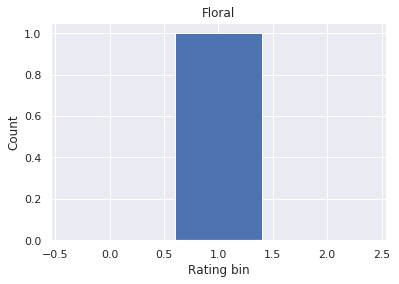

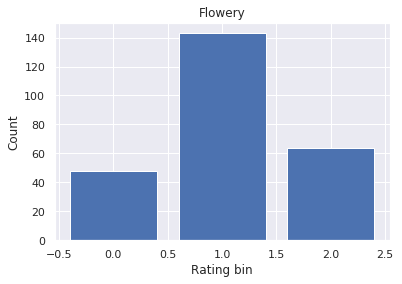

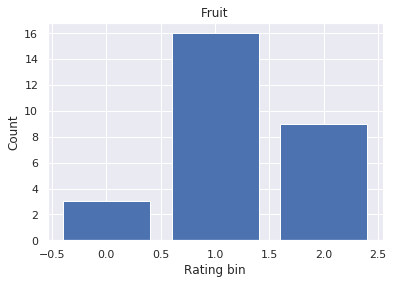

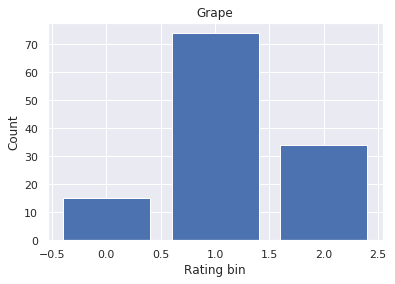

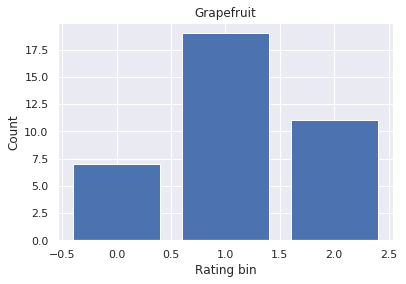

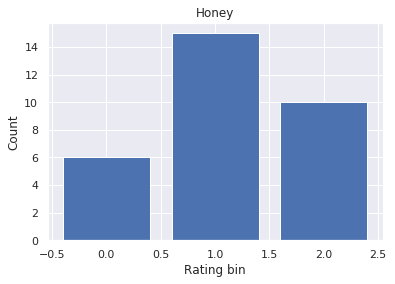

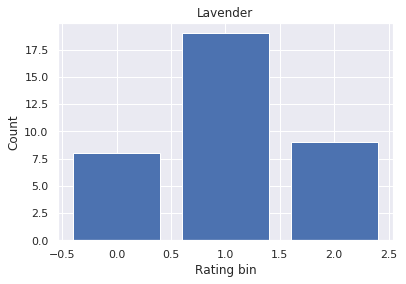

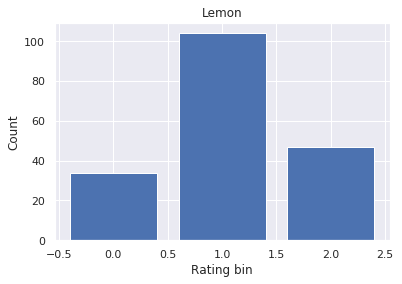

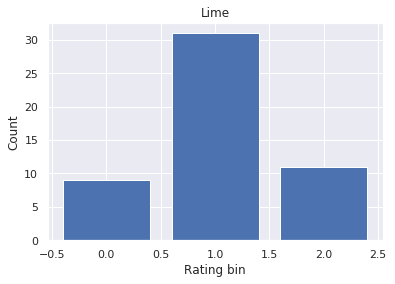

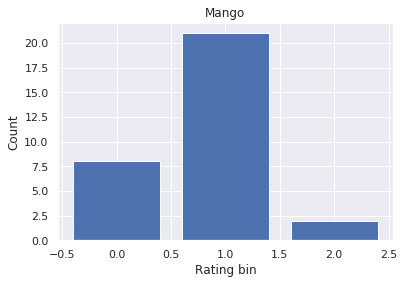

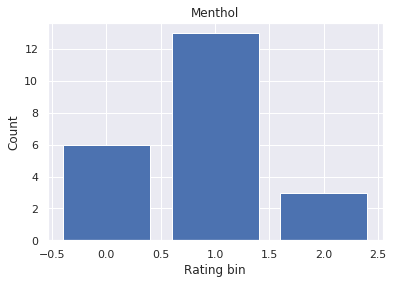

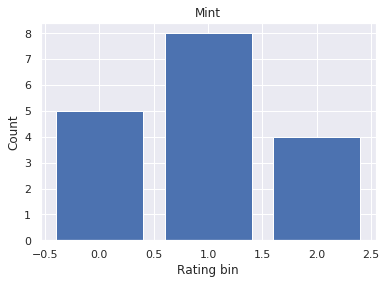

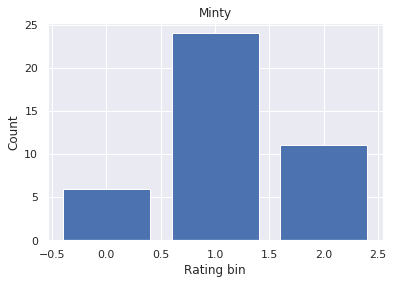

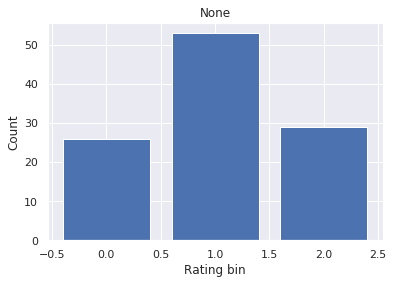

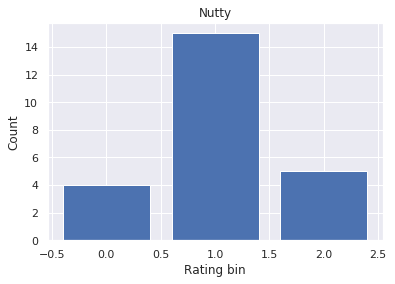

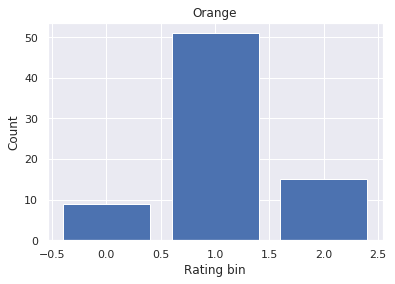

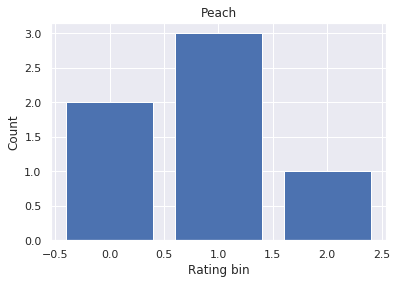

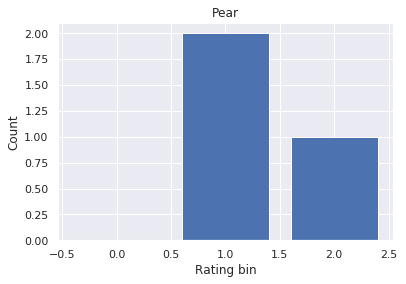

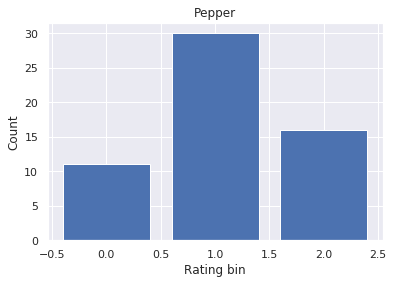

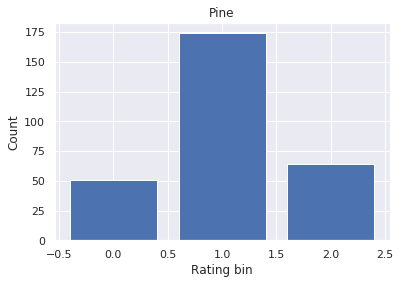

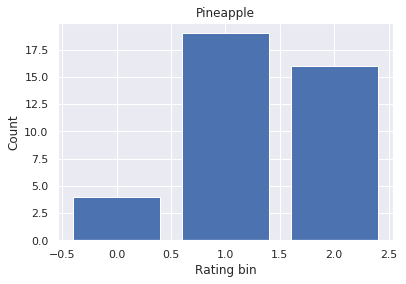

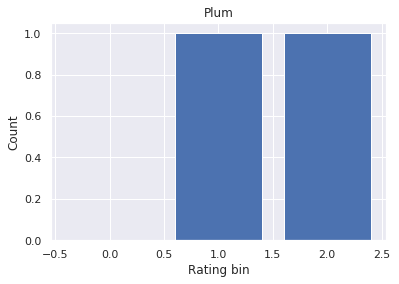

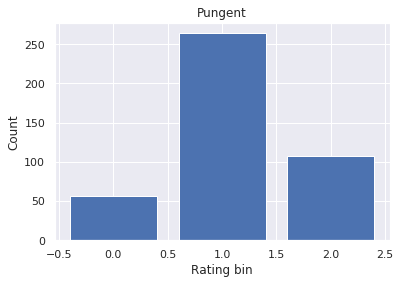

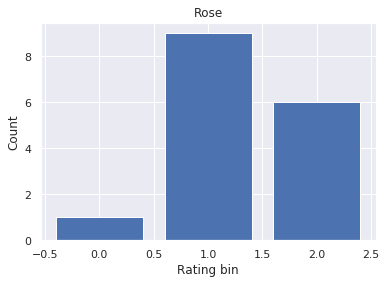

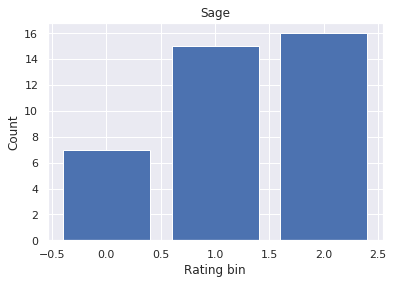

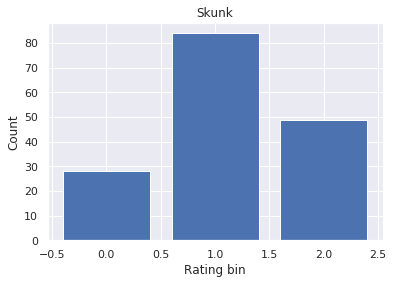

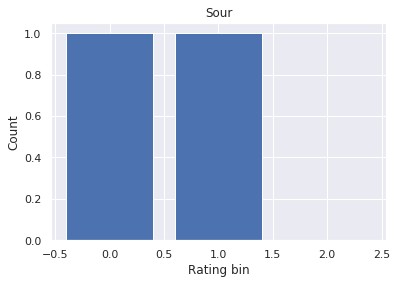

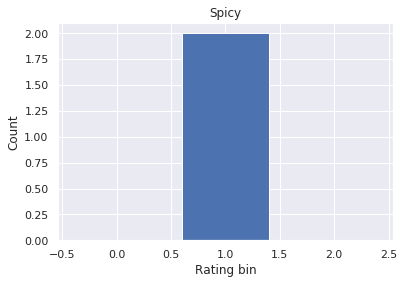

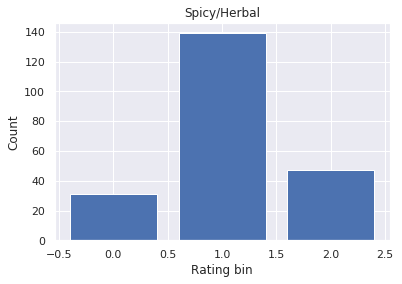

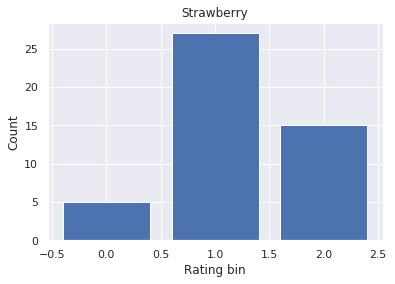

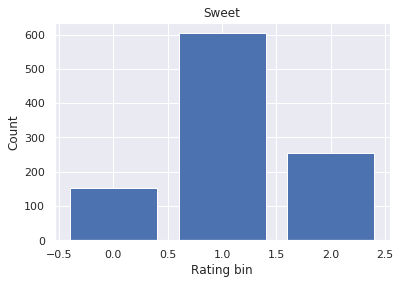

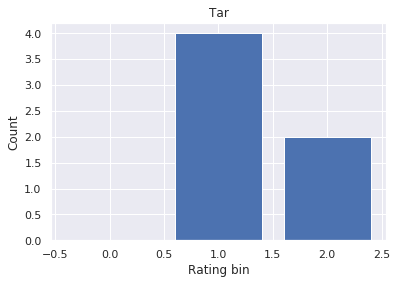

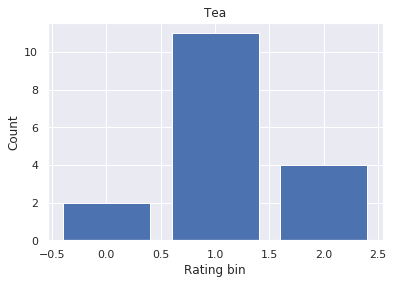

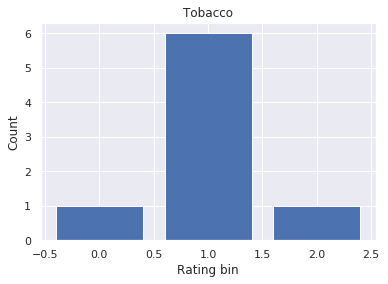

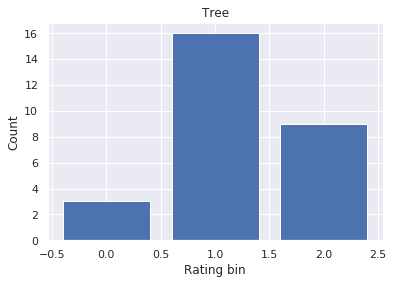

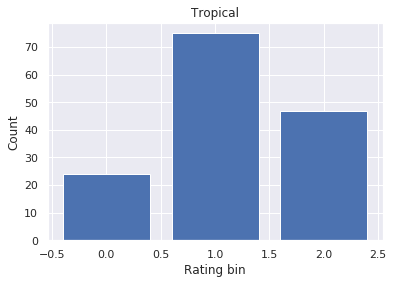

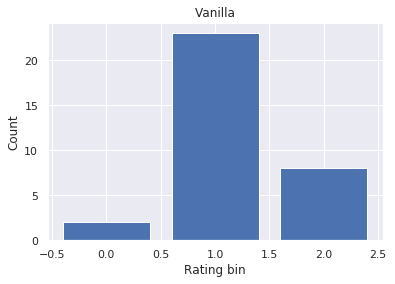

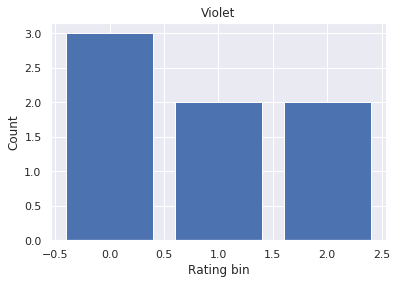

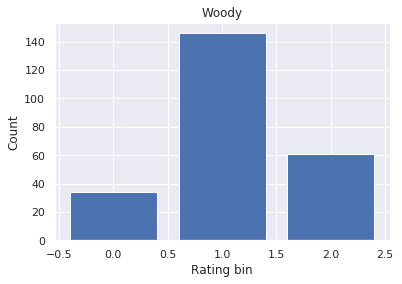

In [0]:
flavor_x = flavor_df.drop(['Type', 'Rating_bin'], axis=1).columns
flavor_df['Rating_bin'].value_counts()
for flavor in flavor_x:
  flavor_sum = []
  flavor_sum.append(flavor_df[flavor_df['Rating_bin'] == 0][flavor].sum())
  flavor_sum.append(flavor_df[flavor_df['Rating_bin'] == 1][flavor].sum())
  flavor_sum.append(flavor_df[flavor_df['Rating_bin'] == 2][flavor].sum())
  plt.bar(x=[0,1,2], height=flavor_sum)
  plt.xlabel('Rating bin')
  plt.ylabel('Count')
  plt.title(flavor)
  plt.show()
  print('\n\n')

Again we can see that each flavor follows the same distribution as the distribution of strains in each bin. With None and null values occuring in strains with lower customer rating. Pepper is an interesting flavor to view since it appears more often in rating bin 2 then bin 1 which is interesting with respect to the amount of strains in bin 2 compared to bin 1

#### After looking at each effect as well as each flavors individually we will look at Effects and Flavors in a more border way.

In [0]:
df1.head()

,Strain,Type,Rating,Effects,Flavor,Description,Rating_bin
0,100-Og,hybrid,4.0,"[Creative, Energetic, Tingly, Euphoric, Relaxed]","[Earthy, Sweet, Citrus]",$100 OG is a 50/50 hybrid strain that packs a ...,0
1,98-White-Widow,hybrid,4.7,"[Relaxed, Aroused, Creative, Happy, Energetic]","[Flowery, Violet, Diesel]",The ‘98 Aloha White Widow is an especially pot...,2
2,1024,sativa,4.4,"[Uplifted, Happy, Relaxed, Energetic, Creative]","[Spicy/Herbal, Sage, Woody]",1024 is a sativa-dominant hybrid bred in Spain...,1
3,13-Dawgs,hybrid,4.2,"[Tingly, Creative, Hungry, Relaxed, Uplifted]","[Apricot, Citrus, Grapefruit]",13 Dawgs is a hybrid of G13 and Chemdawg genet...,1
4,24K-Gold,hybrid,4.6,"[Happy, Relaxed, Euphoric, Uplifted, Talkative]","[Citrus, Earthy, Orange]","Also known as Kosher Tangie, 24k Gold is a 60%...",1


In [0]:
plt.style.use(style='ggplot')
df1.columns

# Dealing with Effects
vis_df = df1.loc[:,['Strain','Type','Rating','Effects','Flavor','Description','Rating_bin','Descr_clean_skl']]
vis_df['Effects']= vis_df['Effects'].apply(','.join)
vis_df['Flavor']= vis_df['Flavor'].apply(','.join)

# Expanding effects
vis_df[['effect1','effect2','effect3','effect4','effect5']] = vis_df.Effects.str.split(",",expand=True)

# Expanding flavor
vis_df[['flavor1','flavor2','flavor3','flavor4']] = vis_df.Flavor.str.split(",",expand=True)

############## Effects ##########################################
effect1_rating = vis_df.loc[:,['Rating','effect1']]
effect1_rating.rename(columns={'effect1':'Effect'},inplace=True)

effect2_rating = vis_df.loc[:,['Rating','effect2']]
effect2_rating.rename(columns={'effect2':'Effect'},inplace=True)

effect3_rating = vis_df.loc[:,['Rating','effect3']]
effect3_rating.rename(columns={'effect3':'Effect'},inplace=True)

effect4_rating = vis_df.loc[:,['Rating','effect4']]
effect4_rating.rename(columns={'effect4':'Effect'},inplace=True)

effect5_rating = vis_df.loc[:,['Rating','effect5']]
effect5_rating.rename(columns={'effect5':'Effect'},inplace=True)

rating_effect = effect1_rating.append([effect2_rating,effect3_rating,effect4_rating,effect5_rating], 
                                      ignore_index=True, sort=True).reindex()
rating_effect.shape

############## Flavor ##########################################
flavor1_rating = vis_df.loc[:,['Rating','flavor1']]
flavor1_rating.rename(columns={'flavor1':'flavor'},inplace=True)

flavor2_rating = vis_df.loc[:,['Rating','flavor2']]
flavor2_rating.rename(columns={'flavor2':'flavor'},inplace=True)

flavor3_rating = vis_df.loc[:,['Rating','flavor3']]
flavor3_rating.rename(columns={'flavor3':'flavor'},inplace=True)

flavor4_rating = vis_df.loc[:,['Rating','flavor4']]
flavor4_rating.rename(columns={'flavor4':'flavor'},inplace=True)

rating_flavor = flavor1_rating.append([flavor2_rating,flavor3_rating,flavor4_rating],
                                     ignore_index=True, sort=True).reindex()

rating_flavor.shape

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


(9136, 2)

In [0]:
def replace_rating(x):
    Rating= x['Rating']
    if (Rating >=0) and (Rating <=1.5):
        return 1
    elif (Rating >1.5) and (Rating <=2.5):
        return 2
    elif (Rating >2.5) and (Rating <=3.5):
        return 3
    elif (Rating >3.5) and (Rating <=4.5):
        return 4
    elif (Rating > 4.5):
        return 5
    else:
        return 0

rating_effect['Rating'] = rating_effect.apply(replace_rating, axis=1)
rating_flavor['Rating'] = rating_flavor.apply(replace_rating, axis=1)

In [0]:
def replace_rating(x):
    Rating= x['Rating']
    if (Rating >=0) and (Rating <=1.5):
        return 1
    elif (Rating >1.5) and (Rating <=2.5):
        return 2
    elif (Rating >2.5) and (Rating <=3.5):
        return 3
    elif (Rating >3.5) and (Rating <=4.5):
        return 4
    elif (Rating > 4.5):
        return 5
    else:
        return 0

rating_effect['Rating'] = rating_effect.apply(replace_rating, axis=1)
rating_flavor['Rating'] = rating_flavor.apply(replace_rating, axis=1)

In [0]:
### Pivot Table Rating and Effects
rating_effects = pd.crosstab(rating_effect['Effect'],rating_effect['Rating'])
rating_effects

Rating,1,2,3,4,5
Effect,,,,,
Aroused,3,0,5,96,92
Creative,4,0,12,421,285
Dry,0,0,0,1,0
Energetic,1,0,12,402,207
Euphoric,6,0,13,1007,568
Focused,3,0,9,359,215
Giggly,4,1,4,172,101
Happy,6,0,19,1156,646
Hungry,4,0,7,309,142


# Most people agreed that Cannabis makes them feel happy! :)

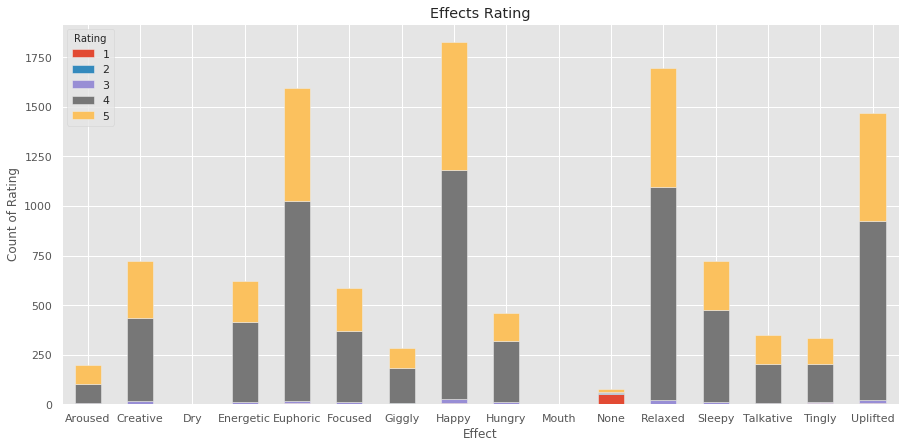

In [0]:
rating_effects.plot(kind='bar', stacked=True, rot = 0, figsize=(15, 7));
plt.title('Effects Rating')
plt.ylabel('Count of Rating')
plt.show()

In [0]:
### Pivot Table Rating and Flavors
rating_flavors = pd.crosstab(rating_flavor['flavor'],rating_flavor['Rating'])
rating_flavors.head(10)

Rating,1,2,3,4,5
flavor,,,,,
Ammonia,0,0,1,15,12
Apple,1,0,0,9,6
Apricot,0,0,0,6,2
Berry,1,0,2,204,147
Blue,0,0,0,9,0
Blueberry,0,0,1,90,53
Butter,0,0,2,10,7
Cheese,1,0,2,49,15
Chemical,0,0,0,22,14


## Most people like Earthy and Sweet flavors

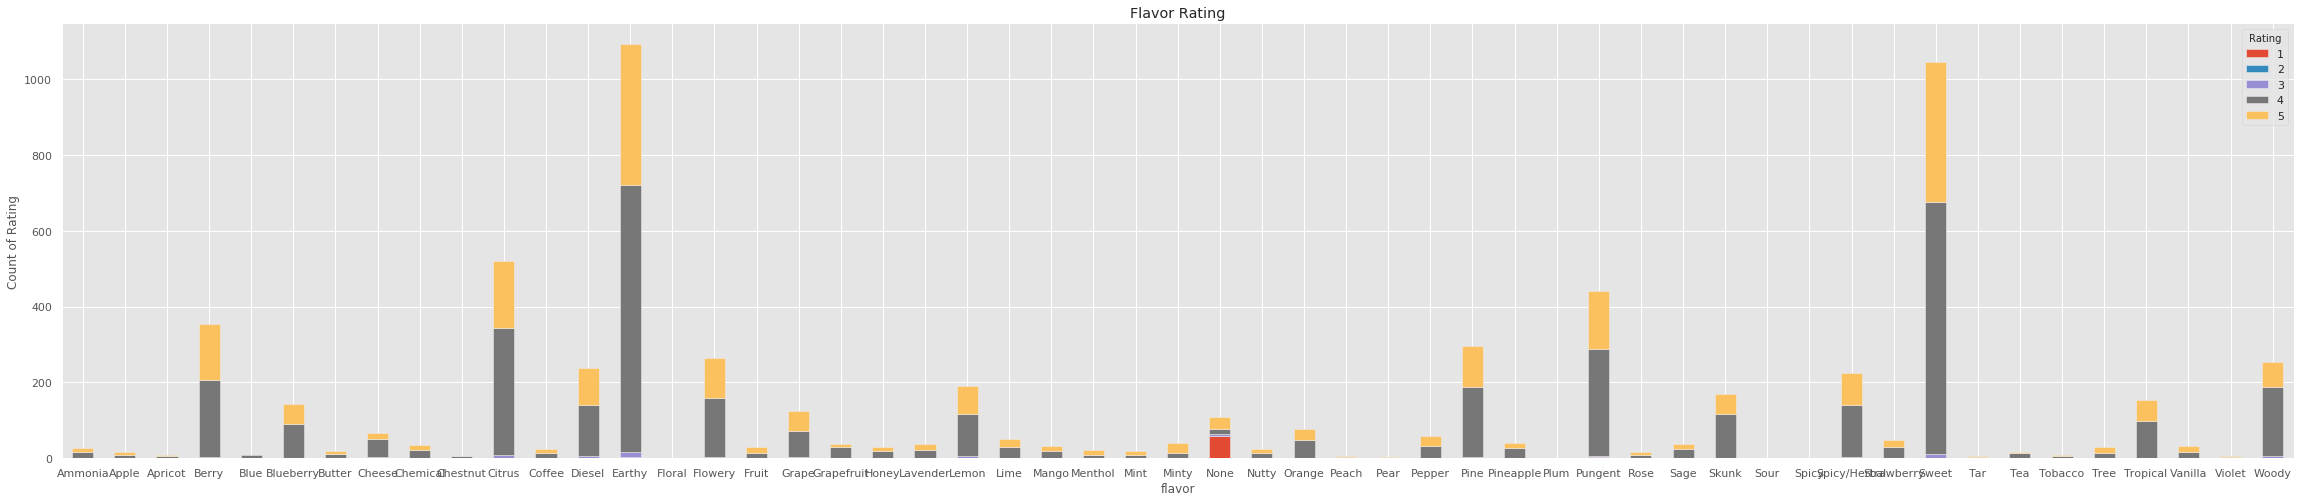

In [0]:
rating_flavors.plot(kind='bar', stacked=True, rot = 0, figsize=(40, 8));
plt.title('Flavor Rating')
plt.ylabel('Count of Rating')
plt.show()

In [0]:
############## Type ##########################################
type_rating = vis_df.loc[:,['Type','Rating']]
type_rating['Rating'] = type_rating.apply(replace_rating, axis=1)
type_rating

rating_types = pd.crosstab(type_rating['Type'],type_rating['Rating'])
rating_types

Rating,1,2,3,4,5
Type,,,,,
hybrid,39,1,17,696,421
indica,16,1,7,407,250
sativa,12,0,9,262,146


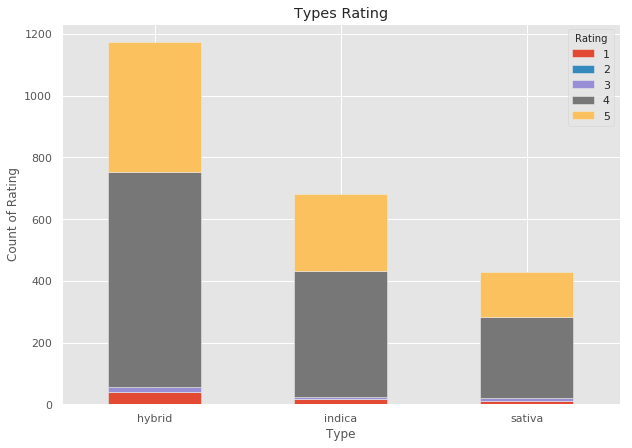

In [0]:
rating_types.plot(kind='bar', stacked=True, rot = 0, figsize=(10, 7));
plt.title('Types Rating')
plt.ylabel('Count of Rating')
plt.show()

In [0]:
############## Strain ##########################################
strain_rating = vis_df.loc[:,['Strain','Rating']]
strain_rating.Strain.value_counts()

Jungle-Juice              1
Pineapple-Purple-Skunk    1
Cherry-Sauce              1
Damnesia                  1
Very-Berry-Haze           1
Richie-Rich               1
Sugar-Shack               1
Proper-Pho-Shatter-H      1
Hippie-Crippler           1
Burnt-Cookies             1
Mandala-1                 1
Kobain-Kush               1
Nightmare-Cookies         1
Euphoria-Cookies          1
Money-Maker               1
Chocolate-Sap             1
Hashberry                 1
Afghan-Kush               1
Urkle-Train-Haze          1
Chicle                    1
Kona-Gold                 1
Blackberry-Trainwreck     1
Six-Shooter               1
Magic-Jordan              1
Mossad                    1
Shipwreck                 1
Blackberry-Pie            1
91-Krypt                  1
Green-Python              1
Green-Line-Og             1
                         ..
Agent-Orange              1
Madman-Og                 1
Capleton                  1
Sojay-Haze                1
Blue-Wreck          

### Visualize the descriptions


Average length of a Description is: 454.8073555166375


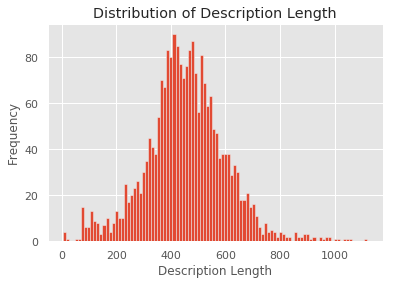

In [0]:
# First visualizing the typical length of each Description
Description_length = df1['Description'].apply(len)
print('\nAverage length of a Description is:', Description_length.mean())
Description_length.plot(kind='hist', bins=100)
plt.title('Distribution of Description Length')
plt.xlabel("Description Length")
plt.show()

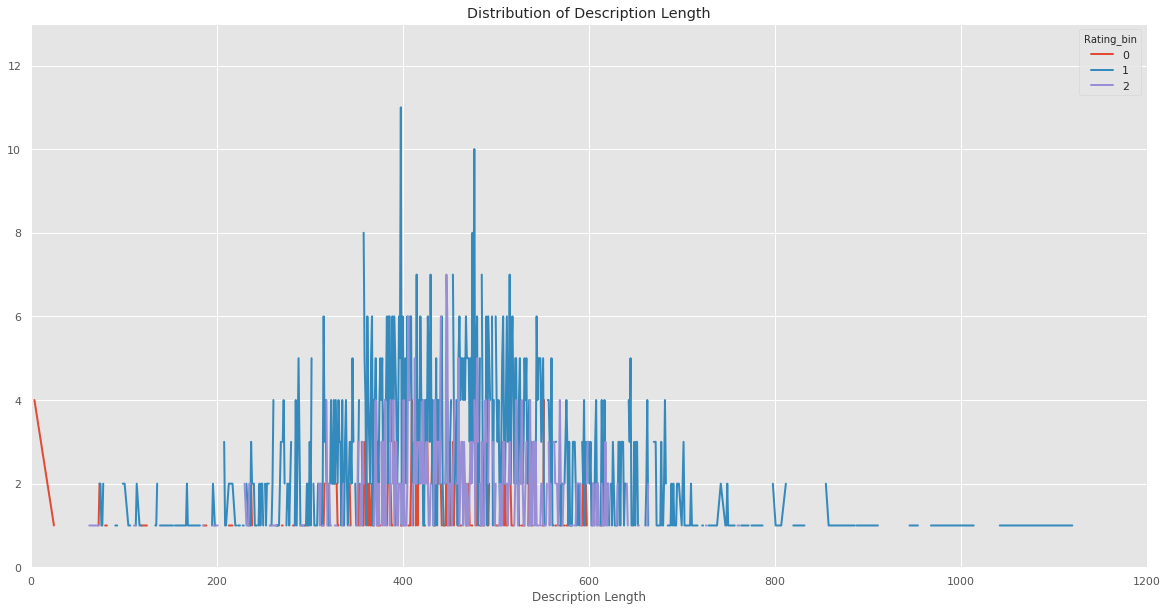

In [0]:
# Seeing if there is a pattern between the length of the description and the cutomer rating
df1['Description_len'] = df1['Description'].apply(len)
# print(df1['Rating_bin'])
fig, ax = plt.subplots(figsize=(20,10))
df1.groupby(['Description_len', 'Rating_bin'])['Description_len'].count().unstack().plot(ax=ax, linewidth=2)
plt.ylim(0,13)
plt.xlim(0,1200)
plt.xlabel("Description Length")
plt.title('Distribution of Description Length')
plt.show()

We can observe that the strains with very small descriptions under 50 words are only seen in the rating bin 0 which is customer rating under 4.2.
<br>
These graphs there is a normal distribution with regards to the length of the descriptions.

In [0]:
## The most common words in the descriptions based on the different rating bins
pip install wordcloud

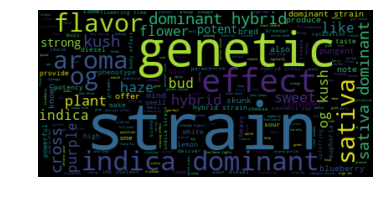

In [0]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
% matplotlib inline


## Combine all words in the original descriptions to one long string then apply the wordcloud on it
stop_words = stopwords.words('english')
text = [SnowballStemmer(language='english').stem(w) for w in df1['Description']]
text = " ".join(word for word in text)
wordcloud = WordCloud(stopwords=stop_words).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Since there are some words that are seen frequently through all descriptions we will add those to the stop words to observe more unqiues words that have strong effect on the different ratings

In [0]:
new_stop_words = stop_words +\
  ['strain','genetic','sativa','hybrid','indica','effect','plant','aroma','dominant',
   'genetics','effects','flavor','bred','like','cannabis','cross','kush','og','bud','buds','note','flavors','notes']


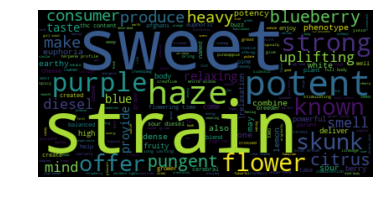

In [0]:
## All strains with new stop words
text = [SnowballStemmer(language='english').stem(w) for w in df1['Description']]
text = " ".join(word for word in text)
wordcloud = WordCloud(stopwords=new_stop_words).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

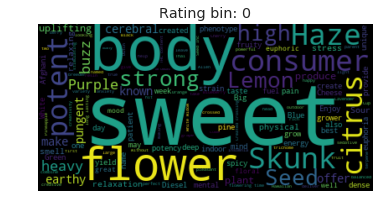

In [0]:
# Now looking into the word clouds that are for each rating category
bin_0_review_text = [SnowballStemmer(language='english').stem(w) for w in df1['Description']]
bin_0_review_text = " ".join(description for description in df1.loc[df1['Rating_bin']==0]['Description'])
wordcloud = WordCloud(stopwords=new_stop_words).generate(bin_0_review_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Rating bin: 0')
plt.axis('off')
plt.show()

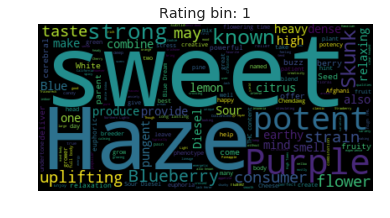

In [0]:
# Now looking into the word clouds that are for each rating category
bin_1_review_text = [SnowballStemmer(language='english').stem(w) for w in df1['Description']]
bin_1_review_text = " ".join(description for description in df1.loc[df1['Rating_bin']==1]['Description'])
wordcloud = WordCloud(stopwords=new_stop_words).generate(bin_1_review_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Rating bin: 1')
plt.axis('off')
plt.show()

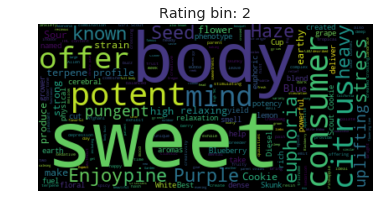

In [0]:
# Now looking into the word clouds that are for each rating category
bin_2_review_text = [SnowballStemmer(language='english').stem(w) for w in df1['Description']]
bin_2_review_text = " ".join(description for description in df1.loc[df1['Rating_bin']==2]['Description'])
wordcloud = WordCloud(stopwords=new_stop_words).generate(bin_2_review_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Rating bin: 2')
plt.axis('off')
plt.show()

Through these word clouds we can see that flower frequently observed in bin 0 and is less common in bin 1 or bin 2, 
 
 Another word tha stands out is potent which is seen much more frequently in bin 1 and bin 2 than seen in bin 0.
 
 Haze is less frequently observered in the highest cutomer rating compared to rating less than 4.7.

Description has the most influence on the models since we have to convert the words to vectors. This will drastically increase the amount of attributes in the models which if not carefull can minimize the influence of the other attributes. To combat this we have duplicated the type attribute multiple times, this will allow the Type attribute to have an equal weight compared to Description. 
Effect and Flavor can often be seen already in the description making those two attributes less important in the models and could poteinally be added into the descriptions.




<H3>
The first step is to do the most basic preprocessing: removeing null values and fixing data types
</H3>

In [0]:
# #drop rows with missing values
# df1 = df1.loc[pd.isnull(df1['Effects']) == False]
# df1 = df1.loc[pd.isnull(df1['Flavor']) == False]
# df1 = df1.loc[pd.isnull(df1['Description']) == False]

In [0]:
#convert dtypes
str_cols = ['Effects',
            'Flavor',
            'Description']

for col in str_cols:
    df1[col] = df1[col].astype(str)

In [0]:
# #bin the target variable
# bins = np.array([4.2, 4.7])

# df1['Rating_bin'] = np.digitize(df1['Rating'], bins=bins)

<H3>
The next step is to check if we need to oversample or undersample for imbalanced classes
</H3>

In [0]:
#define percentage function
def add_pct_bar(ax, total_count):
    """
    adds percentage subtotals above bars in a seaborn bar/count plot
    requies the seaborn plot (ax)
    requires the total number of observations (total_count)
    """
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.,
                height + 10,
                '{:.1%} ({:01.0f})'.format(height/total_count, height),
                ha='center')

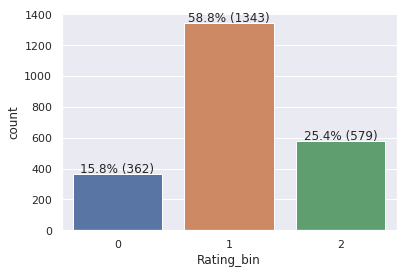

In [0]:
#create a bar chart for the classes
sns.set()

fig_class_1 = sns.countplot(df1['Rating_bin'])
add_pct_bar(fig_class_1, len(df1))

In [0]:
print(df1.groupby(['Rating_bin'])['Rating_bin'].count())

Rating_bin
0     362
1    1343
2     579
Name: Rating_bin, dtype: int64


It is clear from the chart and table above that the data is imbalanced. The balance the data, the data labelled as either class 0 or class 2 will be oversampled. Class 0 will be oversample 3 times, and class 2 twice. 

In [0]:
#create dataframes for the 0 and 2 classes
class_0 = df1.loc[df1['Rating_bin'] == 0]
class_2 = df1.loc[df1['Rating_bin'] == 2]

In [0]:
#drop the 0 and 2 classes from the main dataframe
df1 = df1.loc[df1['Rating_bin'] != 0]
df1 = df1.loc[df1['Rating_bin'] != 2]

print(df1['Rating_bin'].unique())

[1]


In [0]:
#oversample class 0
df1 = pd.concat([df1, class_0])
df1 = pd.concat([df1, class_0])
df1 = pd.concat([df1, class_0])

In [0]:
#oversample class 2
df1 = pd.concat([df1, class_2])
df1 = pd.concat([df1, class_2])

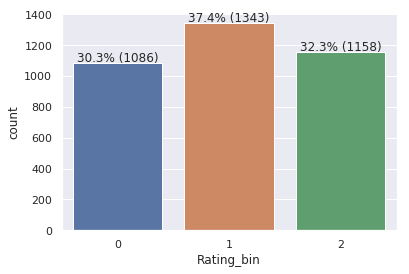

In [0]:
#check the distribution of oversampled classes
sns.set()

fig_class_2 = sns.countplot(df1['Rating_bin'])
add_pct_bar(fig_class_2, len(df1))

In [0]:
#create a copy of the dataframe so that we have one for Scikit-learn and one for gensim
df2 = df1

<H3>
    The following section shows one method of preprocessing the text using scikit-learn's Count Vectorizer and TF-IDF. This is a bag of words model that will count instances of words in the text, and then compute the term frequency-inverse document frequency to assess the importance of words.
    
    
However, before using TF-IDF, the data needs to be cleaned. This will involved using tools from the NLTK library to make the words lower case, stem them, tokenize, remove stopwords, and, in this case, rejoin them so that they work with scikit-learn's functions.
</H3>

In [0]:
#define the cleaning function for scikit learn
def clean_text_skl(text):
    
    #make all words lowercase
    clean_skl = text.lower()
    
    #tokenize and remove special characters
    tokenizer = RegexpTokenizer(r'\w+')
    clean_skl = tokenizer.tokenize(clean_skl)
        
    #lemmatize the text
#     clean_skl = [WordNetLemmatizer().lemmatize(w) for w in clean_skl]
    clean_skl = [SnowballStemmer(language='english').stem(w) for w in clean_skl]
        
    #remove stopwords
    clean_skl = [token for token in clean_skl if not token in stopwords.words('english')]
    clean_skl = ' '.join(clean_skl)
    
    return clean_skl

In [0]:
#clean the text features
for col in str_cols:
    df1[col + '_clean_skl'] = df1[col].apply(clean_text_skl)

In [0]:
#instantiate the vectorizer pipeline
vectorizer = CountVectorizer()
tfidf = TfidfTransformer()

pipe_preprocess = make_pipeline(vectorizer, tfidf)

In [0]:
#transform text fetures
Descr_array = pipe_preprocess.fit_transform(df1['Description_clean_skl']).todense()
Effects_array = pipe_preprocess.fit_transform(df1['Effects_clean_skl']).todense()
Flavor_array = pipe_preprocess.fit_transform(df1['Flavor_clean_skl']).todense()

Now that the text features have been turned into numpy arrays, we are able to start training the models. However, one issue remains. Each feature - Decription, Effects, and Flavor - is one column in the dataset. However, because the text in Description is so much longer, it ends up being many more columns in the numpy array than the other two features. In order to stop the models from ignoring Effects and Flavor, they will be added to the feature matrix more than once to compensate

In [0]:
#determine length of each feature set
print('Description has {} columns'.format(str(Descr_array.shape[1:2])))
print('Flavor has {} columns'.format(str(Flavor_array.shape[1:2])))
print('Effects has {} columns'.format(str(Effects_array.shape[1:2])))

Description has (6218,) columns
Flavor has (53,) columns
Effects has (16,) columns


In [0]:
#create repeated Flavor feature
flavor_array_rep = np.repeat(Flavor_array, 100, axis=1)

In [0]:
#create repeated Effects feature
effects_array_rep = np.repeat(Effects_array, 500, axis=1)

In [0]:
#create X and transform it into a dense matrix
X = np.concatenate([Descr_array, flavor_array_rep, effects_array_rep], axis=1)
X = csr_matrix(X)

In [0]:
# X = descr_model[descr_model.wv.vocab]
y = df1['Rating_bin']

In [0]:
#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=54, test_size=0.3, stratify=y)

SGD Classifier

In [0]:
#SGD Classifier
sgd = SGDClassifier()

params_sgd = {'loss': ['hinge', 'log'],
              'penalty': ['l1', 'l2'],
              'alpha': [0.01, 0.05],
              'max_iter': [1000, 2000]}

grid_sgd = GridSearchCV(sgd, param_grid=params_sgd, scoring='accuracy', cv=3)

grid_sgd.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.01, 0.05], 'loss': ['hinge', 'log'],
                         'max_iter': [1000, 2000], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True

In [0]:
#create model with the best estimators from the grid search
model_sgd = grid_sgd.best_estimator_

In [0]:
#save the model for later testing
# model_dir = 'C:/Users/taylor.vanvalkenburg/Desktop/Files/MyStuff/School/ML/Final/Models/'

# joblib.dump(model_sgd, os.path.join(model_dir + 'skl_sgd_model.sav'))

In [0]:
#get the models score in cross-validation on the training set with 10 folds
crossval_sgd_10 = cross_val_score(model_sgd, X_train, y_train, cv=10, scoring='accuracy')
print(crossval_sgd_10)
print(crossval_sgd_10.mean())

[0.47808765 0.44223108 0.51394422 0.47808765 0.47410359 0.52988048
 0.48207171 0.47410359 0.45816733 0.5059761 ]
0.4836653386454183


In [0]:
#get the models score in cross-validation on the training set with 3 folds
crossval_sgd_3 = cross_val_score(model_sgd, X_train, y_train, cv=3, scoring='accuracy')
print(crossval_sgd_3)
print(crossval_sgd_3.mean())

[0.45704057 0.50717703 0.49043062]
0.48488274276491833


In [0]:
#predict with SGD model
y_pred_sgd = model_sgd.predict(X_test)

Random Forest Classifier

In [0]:
#Random Forest Classifier
rfc = RandomForestClassifier()

params_rfc = {'min_samples_split': [1.0, 2],
              'max_depth': [500, 1000],
              'n_estimators': [500, 1000]}

grid_rfc = GridSearchCV(rfc, param_grid = params_rfc, scoring='accuracy', cv=3)

grid_rfc.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [0]:
#create model with the best estimators from the grid search
model_rfc = grid_rfc.best_estimator_

In [0]:
#save the model for later testing
# model_dir = 'C:/Users/taylor.vanvalkenburg/Desktop/Files/MyStuff/School/ML/Final/Models/'

# joblib.dump(model_rfc, os.path.join(model_dir + 'skl_rfc_model.sav'))

In [0]:
#get the models score in cross-validation on the training set with 10 folds
crossval_rfc_10 = cross_val_score(model_rfc, X_train, y_train, cv=10, scoring='accuracy')
print(crossval_rfc_10)
print(crossval_rfc_10.mean())

[0.73306773 0.78486056 0.79282869 0.73306773 0.80876494 0.7689243
 0.77290837 0.78884462 0.74900398 0.77689243]
0.7709163346613546


In [0]:
#get the models score in cross-validation on the training set with 3 folds
crossval_rfc_3 = cross_val_score(model_rfc, X_train, y_train, cv=3, scoring='accuracy')
print(crossval_rfc_3)
print(crossval_rfc_3.mean())

[0.69331742 0.71889952 0.72727273]
0.713163223746065


In [0]:
#predict with Random Forest model
y_pred_rfc = model_rfc.predict(X_test)

KNN Model

In [0]:
#KNN Classifier
knn = KNeighborsClassifier()

params_knn = {'n_neighbors': [5, 50, 100],
                'p': [1, 2]}

grid_knn = GridSearchCV(knn, param_grid = params_knn, scoring='accuracy', cv=3)

grid_knn.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [5, 50, 100], 'p': [1, 2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [0]:
#create model with the best estimators from the grid search
model_knn = grid_knn.best_estimator_

In [0]:
#save the model for later testing
# model_dir = 'C:/Users/taylor.vanvalkenburg/Desktop/Files/MyStuff/School/ML/Final/Models/'

# joblib.dump(model_knn, os.path.join(model_dir + 'skl_knn_model.sav'))

In [0]:
#get the models score in cross-validation on the training set with 10 folds
crossval_knn_10 = cross_val_score(model_knn, X_train, y_train, cv=10, scoring='accuracy')
print(crossval_knn_10)
print(crossval_knn_10.mean())

[0.47410359 0.44223108 0.5059761  0.47410359 0.52589641 0.52988048
 0.51394422 0.50199203 0.43824701 0.48605578]
0.48924302788844615


In [0]:
#get the models score in cross-validation on the training set with 3 folds
crossval_knn_3 = cross_val_score(model_knn, X_train, y_train, cv=3, scoring='accuracy')
print(crossval_knn_3)
print(crossval_knn_3.mean())

[0.45584726 0.48325359 0.46650718]
0.4685360069733892


In [0]:
#predict with the KNN model
y_pred_knn = model_knn.predict(X_test)

Keras Model

In [0]:
#determine the input shape
input_shape_skl = X_train.shape[1:2]

In [0]:
#one hot encode the target variable
y_train_k = to_categorical(y_train)

In [0]:
#define the model
k_model = Sequential()

k_model.add(Dense(5, activation='relu', input_shape=input_shape_skl))
k_model.add(Dense(5, activation='relu'))
k_model.add(Dense(5, activation='relu'))
k_model.add(Dense(5, activation='relu'))
k_model.add(Dense(3, activation='softmax'))


W0723 14:49:13.844233 139778166699904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 14:49:13.904584 139778166699904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 14:49:13.916463 139778166699904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [0]:
early_stop = [EarlyStopping(monitor='acc', patience=3)]

In [0]:
#compile the model
k_model.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

W0723 14:49:14.017458 139778166699904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0723 14:49:14.056521 139778166699904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [0]:
#train the model
k_model.fit(X_train, 
            y_train_k,
            epochs=50,
            callbacks=early_stop,
            verbose=1)

W0723 14:49:14.224261 139778166699904 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0723 14:49:14.296804 139778166699904 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/50
2510/2510 [==============================] - 2s 694us/step - loss: 1.0677 - acc: 0.4167
Epoch 2/50
2510/2510 [==============================] - 1s 275us/step - loss: 1.0161 - acc: 0.4618
Epoch 3/50
2510/2510 [==============================] - 1s 272us/step - loss: 0.9942 - acc: 0.4821
Epoch 4/50
2510/2510 [==============================] - 1s 284us/step - loss: 0.9894 - acc: 0.4861
Epoch 5/50
2510/2510 [==============================] - 1s 267us/step - loss: 0.9736 - acc: 0.4900
Epoch 6/50
2510/2510 [==============================] - 1s 276us/step - loss: 0.9674 - acc: 0.4980
Epoch 7/50
2510/2510 [==============================] - 1s 270us/step - loss: 0.9623 - acc: 0.5080
Epoch 8/50
2510/2510 [==============================] - 1s 272us/step - loss: 0.9551 - acc: 0.5080
Epoch 9/50
2510/2510 [==============================] - 1s 269us/step - loss: 0.9439 - acc: 0.5124
Epoch 10/50
2510/2510 [==============================] - 1s 277us/step - loss: 0.9377 - acc: 0.5219
Epoch 11/

In [0]:
#predict with Keras model
y_pred_ker = k_model.predict(X_test)

In [0]:
#measure model accuracy
sgd_accuracy = accuracy_score(y_test, y_pred_sgd)
rfc_accuracy = accuracy_score(y_test, y_pred_rfc)
knn_accuracy = accuracy_score(y_test, y_pred_knn)

ker_score, acc_score = k_model.evaluate(X_test, to_categorical(y_test))

print('The test set accuracy for the SGD model is: {}'.format(sgd_accuracy))
print('The test set accuracy  for the Random Forest model is: {}'.format(rfc_accuracy))
print('The test set accuracy  for the KNN model is: {}'.format(knn_accuracy))
print('The test set accuracy  for the Keras model is: {}'.format(acc_score))

1077/1077 [==============================] - 0s 166us/step
The test set accuracy for the SGD model is: 0.5153203342618384
The test set accuracy  for the Random Forest model is: 0.8217270194986073
The test set accuracy  for the KNN model is: 0.5199628597957289
The test set accuracy  for the Keras model is: 0.4930362118375224


In [0]:
#create the classification report for the SGDClassifier model
print(classification_report(y_test, y_pred_sgd))

              precision    recall  f1-score   support

           0       0.65      0.40      0.49       326
           1       0.50      0.73      0.59       403
           2       0.45      0.38      0.41       348

    accuracy                           0.52      1077
   macro avg       0.53      0.50      0.50      1077
weighted avg       0.53      0.52      0.50      1077



In [0]:
#create the classification report for the Random Forest model
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88       326
           1       0.83      0.75      0.79       403
           2       0.79      0.80      0.80       348

    accuracy                           0.82      1077
   macro avg       0.82      0.83      0.82      1077
weighted avg       0.82      0.82      0.82      1077



In [0]:
#create the classification report for the KNN model
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.50      0.67      0.57       326
           1       0.54      0.51      0.52       403
           2       0.54      0.39      0.45       348

    accuracy                           0.52      1077
   macro avg       0.52      0.52      0.52      1077
weighted avg       0.52      0.52      0.51      1077



<H3>
    The models trained on the bag of words model created by CountVectorizer all perform reasonably well; however, a second method of obtaining the feature matrix will be done below for comparison. The method used below is gensim's Word2Vec model. This will use word embeddings, rather than the count vectorizer and TD-IDF, to create the feature matrix. The same models will be run so that the two preprocessing methods can be compared. 
</H3>

First, the data will need to be preprocessed

In [0]:
#define the cleaning function for gensim
def clean_text(text):
    
    #make all words lowercase
    clean = text.lower()
    
    #tokenize and remove special characters
    tokenizer = RegexpTokenizer(r'\w+')
    clean = tokenizer.tokenize(clean)
        
    #lemmatize the text
#     clean_skl = [WordNetLemmatizer().lemmatize(w) for w in clean]
    clean = [SnowballStemmer(language='english').stem(w) for w in clean]
        
    #remove stopwords
    clean = [token for token in clean if not token in stopwords.words('english')]
    
    return clean

In [0]:
#clean the text features
for col in str_cols:
    df2[col + '_clean'] = df2[col].apply(clean_text)

In [0]:
#model data for gensim
sents_descr = df2['Description_clean'].to_list()
sents_effects = df2['Effects_clean'].to_list()
sents_flavor = df2['Flavor_clean'].to_list()

In [0]:
#create the word2vec models
w2v_descr = gensim.models.Word2Vec(sents_descr)
w2v_effects = gensim.models.Word2Vec(sents_effects, min_count=1)
w2v_flavor = gensim.models.Word2Vec(sents_flavor, min_count=1)

W0723 14:50:19.651873 139778166699904 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
W0723 14:50:19.712195 139778166699904 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay


In [0]:
#get the average of the vector for each word vector
#citation for function: https://www.kdnuggets.com/2018/04/robust-word2vec-models-gensim.html
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype='float64')
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector

def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)


In [0]:
# get average document level embeddings to create the feature matrices
w2v_feature_descr= averaged_word_vectorizer(corpus=sents_descr, model=w2v_descr,
                                             num_features=100)

w2v_feature_effects= averaged_word_vectorizer(corpus=sents_effects, model=w2v_effects,
                                             num_features=100)

w2v_feature_flavor= averaged_word_vectorizer(corpus=sents_flavor, model=w2v_flavor,
                                             num_features=100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [0]:
#print the shape of each feature array
print('Description has {} columns'.format(str(w2v_feature_descr.shape[1:2])))
print('Effects has {} columns'.format(str(w2v_feature_effects.shape[1:2])))
print('Flavor has {} columns'.format(str(w2v_feature_flavor.shape[1:2])))

Description has (100,) columns
Effects has (100,) columns
Flavor has (100,) columns


In [0]:
#define X
X_g = np.concatenate([w2v_feature_descr, w2v_feature_effects, w2v_feature_flavor], axis=1)

In [0]:
#define y_g
y_g = df2['Rating_bin']

In [0]:
#split training and test sets
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_g, y_g, random_state=54, test_size=0.3, stratify=y)

SGD Classifer

In [0]:
#SGD Classifier
sgd_g = SGDClassifier()

params_sgd_g = {'loss': ['hinge', 'log'],
              'penalty': ['l1', 'l2'],
              'alpha': [0.01, 0.05],
              'max_iter': [1000, 2000]}

grid_sgd_g = GridSearchCV(sgd_g, param_grid=params_sgd_g, scoring='accuracy', cv=3)

grid_sgd_g.fit(X_train_g, y_train_g)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.01, 0.05], 'loss': ['hinge', 'log'],
                         'max_iter': [1000, 2000], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True

In [0]:
#create model with the best estimators from the grid search
model_sgd_g = grid_sgd_g.best_estimator_

In [0]:
#save the model for later testing
# model_dir = 'C:/Users/taylor.vanvalkenburg/Desktop/Files/MyStuff/School/ML/Final/Models/'

# joblib.dump(model_sgd_g, os.path.join(model_dir + 'gen_sgd_model.sav'))

In [0]:
#get the models score in cross-validation on the training set with 10 folds
crossval_sgd_g_10 = cross_val_score(model_sgd_g, X_train_g, y_train_g, cv=10, scoring='accuracy')
print(crossval_sgd_g_10)
print(crossval_sgd_g_10.mean())

[0.47808765 0.5059761  0.49800797 0.38247012 0.37848606 0.46613546
 0.47011952 0.43824701 0.49003984 0.42629482]
0.45338645418326695


In [0]:
#get the models score in cross-validation on the training set with 3 folds
crossval_rfc_g_3 = cross_val_score(model_sgd_g, X_train_g, y_train_g, cv=3, scoring='accuracy')
print(crossval_rfc_g_3)
print(crossval_rfc_g_3.mean())

[0.47852029 0.44497608 0.46172249]
0.4617396169964943


In [0]:
#predict with SGD model
y_pred_sgd_g = model_sgd_g.predict(X_test_g)

Random Forest model

In [0]:
#Random Forest Classifier
rfc_g = RandomForestClassifier()

params_rfc_g = {'min_samples_split': [1.0, 2],
              'max_depth': [500, 1000],
              'n_estimators': [500, 1000]}

grid_rfc_g = GridSearchCV(rfc_g, param_grid = params_rfc_g, scoring='accuracy', cv=3)

grid_rfc_g.fit(X_train_g, y_train_g)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [0]:
#create model with the best estimators from the grid search
model_rfc_g = grid_rfc_g.best_estimator_

In [0]:
#save the model for later testing
# model_dir = 'C:/Users/taylor.vanvalkenburg/Desktop/Files/MyStuff/School/ML/Final/Models/'

# joblib.dump(model_rfc_g, os.path.join(model_dir + 'gen_rfc_model.sav'))

In [0]:
#get the models score in cross-validation on the training set with 10 folds
crossval_rfc_g_10 = cross_val_score(model_rfc_g, X_train_g, y_train_g, cv=10, scoring='accuracy')
print(crossval_rfc_g_10)
print(crossval_rfc_g_10.mean())

[0.79681275 0.78884462 0.812749   0.812749   0.812749   0.81673307
 0.8247012  0.78884462 0.78884462 0.82071713]
0.8063745019920319


In [0]:
#get the models score in cross-validation on the training set with 3 folds
crossval_rfc_g_3 = cross_val_score(model_rfc_g, X_train_g, y_train_g, cv=3, scoring='accuracy')
print(crossval_rfc_g_3)
print(crossval_rfc_g_3.mean())

[0.71002387 0.71650718 0.72966507]
0.7187320383840922


In [0]:
#predict with Random Forest model
y_pred_rfc_g = model_rfc_g.predict(X_test_g)

KNN Model

In [0]:
#KNN Classifier
knn_g = KNeighborsClassifier()

params_knn_g = {'n_neighbors': [5, 50, 100],
                'p': [1, 2]}

grid_knn_g = GridSearchCV(knn_g, param_grid = params_knn_g, scoring='accuracy', cv=5)

grid_knn_g.fit(X_train_g, y_train_g)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [5, 50, 100], 'p': [1, 2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [0]:
#create model with the best estimators from the grid search
model_knn_g = grid_knn_g.best_estimator_

In [0]:
#save the model for later testing
# model_dir = 'C:/Users/taylor.vanvalkenburg/Desktop/Files/MyStuff/School/ML/Final/Models/'

# joblib.dump(model_knn_g, os.path.join(model_dir + 'gen_knn_model.sav'))

In [0]:
#get the models score in cross-validation on the training set with 10 folds
crossval_knn_g_10 = cross_val_score(model_knn_g, X_train_g, y_train_g, cv=10, scoring='accuracy')
print(crossval_knn_g_10)
print(crossval_knn_g_10.mean())

[0.50199203 0.5059761  0.55776892 0.51394422 0.46215139 0.51394422
 0.47808765 0.48605578 0.48207171 0.50199203]
0.500398406374502


In [0]:
#get the models score in cross-validation on the training set with 3 folds
crossval_knn_g_3 = cross_val_score(model_knn_g, X_train_g, y_train_g, cv=3, scoring='accuracy')
print(crossval_knn_g_3)
print(crossval_knn_g_3.mean())

[0.48329356 0.47727273 0.47248804]
0.4776847738787193


In [0]:
#predict with the KNN model
y_pred_knn_g = model_knn_g.predict(X_test_g)

Keras Model

In [0]:
#determine the input shape
input_shape_g = X_train_g.shape[1:2]

In [0]:
#one hot encode the target variable
y_train_k_g = to_categorical(y_train_g)

In [0]:
#define the model
k_model_g = Sequential()

k_model_g.add(Dense(5, activation='relu', input_shape=input_shape_g))
k_model_g.add(Dense(5, activation='relu'))
k_model_g.add(Dense(5, activation='relu'))
k_model_g.add(Dense(5, activation='relu'))
k_model_g.add(Dense(3, activation='softmax'))


In [0]:
#add early stopping
early_stop = [EarlyStopping(monitor='acc', patience=3)]

In [0]:
#compile the model
k_model_g.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [0]:
#train the model
k_model_g.fit(X_train_g, 
              y_train_k_g,
              epochs=50,
              callbacks=early_stop,
              verbose=1)

Epoch 1/50
2510/2510 [==============================] - 0s 173us/step - loss: 1.0975 - acc: 0.3685
Epoch 2/50
2510/2510 [==============================] - 0s 46us/step - loss: 1.0942 - acc: 0.3837
Epoch 3/50
2510/2510 [==============================] - 0s 43us/step - loss: 1.0868 - acc: 0.4259
Epoch 4/50
2510/2510 [==============================] - 0s 47us/step - loss: 1.0714 - acc: 0.4275
Epoch 5/50
2510/2510 [==============================] - 0s 45us/step - loss: 1.0540 - acc: 0.4367
Epoch 6/50
2510/2510 [==============================] - 0s 46us/step - loss: 1.0464 - acc: 0.4315
Epoch 7/50
2510/2510 [==============================] - 0s 47us/step - loss: 1.0452 - acc: 0.4331
Epoch 8/50
2510/2510 [==============================] - 0s 45us/step - loss: 1.0428 - acc: 0.4335


In [0]:
#predict with Keras model
y_pred_ker_g = k_model_g.predict(X_test_g)

In [0]:
#measure model accuracy
sgd_accuracy_g = accuracy_score(y_test_g, y_pred_sgd_g)
rfc_accuracy_g = accuracy_score(y_test_g, y_pred_rfc_g)
knn_accuracy_g = accuracy_score(y_test_g, y_pred_knn_g)

ker_score_g, acc_score_g = k_model_g.evaluate(X_test_g, to_categorical(y_test_g))

print('The test set accuracy  for the SGD model is: {}'.format(sgd_accuracy_g))
print('The test set accuracy  for the Random Forest model is: {}'.format(rfc_accuracy_g))
print('The test set accuracy  for the KNN model is: {}'.format(knn_accuracy_g))
print('The test set accuracy  for the Keras model is: {}'.format(acc_score_g))

1077/1077 [==============================] - 0s 79us/step
The test set accuracy  for the SGD model is: 0.5060352831940576
The test set accuracy  for the Random Forest model is: 0.841225626740947
The test set accuracy  for the KNN model is: 0.5283194057567316
The test set accuracy  for the Keras model is: 0.4484679670165619


In [0]:
#print the classification report for the SGD model
print(classification_report(y_test_g, y_pred_sgd_g))

              precision    recall  f1-score   support

           0       0.59      0.46      0.52       326
           1       0.54      0.52      0.53       403
           2       0.43      0.53      0.47       348

    accuracy                           0.51      1077
   macro avg       0.52      0.50      0.51      1077
weighted avg       0.52      0.51      0.51      1077



In [0]:
#print the classification report for the KNN model
print(classification_report(y_test_g, y_pred_knn_g))

              precision    recall  f1-score   support

           0       0.49      0.65      0.56       326
           1       0.52      0.51      0.51       403
           2       0.60      0.44      0.51       348

    accuracy                           0.53      1077
   macro avg       0.54      0.53      0.53      1077
weighted avg       0.54      0.53      0.53      1077



In [0]:
#print the classification report for the Random Forest model
print(classification_report(y_test_g, y_pred_rfc_g))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       326
           1       0.82      0.81      0.82       403
           2       0.81      0.80      0.80       348

    accuracy                           0.84      1077
   macro avg       0.84      0.84      0.84      1077
weighted avg       0.84      0.84      0.84      1077

